In [204]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
import statistics
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve

%matplotlib inline
print(tf.__version__)

2.10.1


Number of images: 1644
Mean: 104.99878345498783
Geometric mean: 91.36642048787509
Median: 81.0
Min: 48
Max: 711


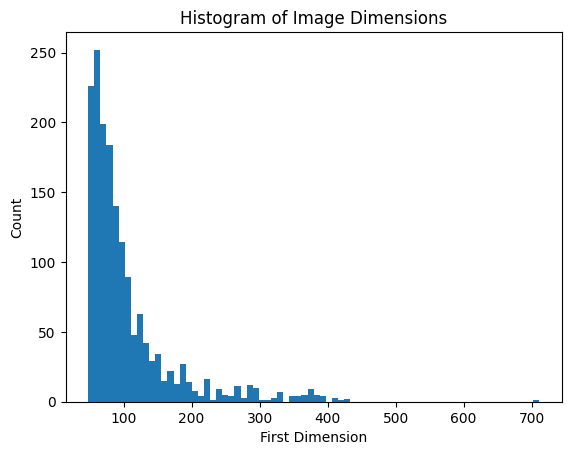

In [205]:
dataset = "../mldataset/cropped"
dirs = [os.path.join(dataset, "Meteors"), os.path.join(dataset, "Artifacts")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        img = os.path.join(i, j)

        if "synthesized" in img:

            for synth in os.listdir(img):
                img3 = os.path.join(img, synth)

                img2 = Image.open(img3)
                img_array = np.array(img2)
                dimensions.append(img_array.shape[0])
                img_array = np.expand_dims(img_array, axis=-1)
        else:
            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Mean:", np.mean(dimensions))
print("Geometric mean:", statistics.geometric_mean(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [206]:
confirmed_num = 0

confirmed_num += len(os.listdir(dirs[0]))
print("Number of meteor images:", confirmed_num)

rejected_images = []
rejected_num = 0

for filename in os.listdir(dirs[1]):
    if "synthesized" in filename:
        rejected_images += [
            os.path.join(dirs[1], filename, synth)
            for synth in os.listdir(os.path.join(dirs[1], filename))
        ]
    else:
        rejected_images.append(os.path.join(dirs[1], filename))

rejected_num = len(rejected_images)
print("Number of artifact images:", rejected_num)

Number of meteor images: 822
Number of artifact images: 822


Class balancing using image augmentation


In [207]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomZoom(0.2, 0.2),
    ]
)

# balance classes by using data augmentation
while rejected_num < confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    if "synthesized" in random_image_path:
        continue
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)

    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(dirs[1], "synthesized", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", base_filename + "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of meteor images:", confirmed_num)
print("Number of artifact images:", rejected_num)

Classes balanced.
Number of meteor images: 822
Number of artifact images: 822


Dataset creation


In [208]:
IMG_SIZE = int(np.median(dimensions))  # seems about right
BATCH_SIZE = 32
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    crop_to_aspect_ratio=True,
)

class_names = train_ds.class_names

Found 1644 files belonging to 2 classes.
Using 1151 files for training.
Using 493 files for validation.


Dataset normalization


In [209]:
def standardize_image(image, label):
    """
    Linearly scales each image in image to have mean 0 and variance 1.
    """
    image = rescale(image)
    image = tf.image.per_image_standardization(image)
    #
    return image, label


AUTOTUNE = tf.data.AUTOTUNE

rescale = layers.Rescaling(1.0 / 255)
# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

# buffered prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Dataset image visualization


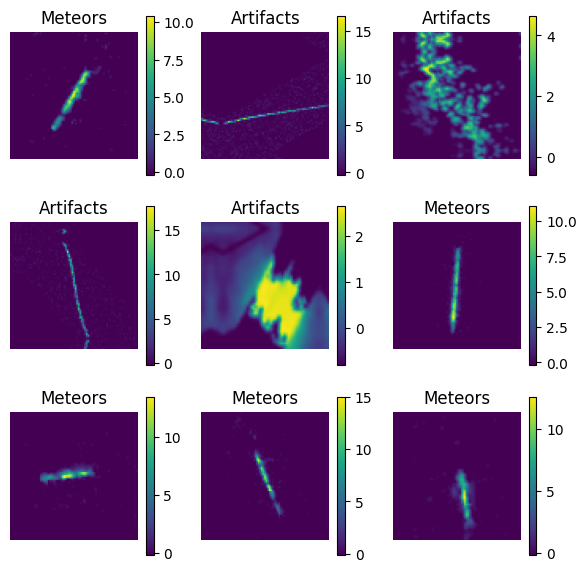

In [210]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("float32")
        # print(img.min(), img.max())

        # img = tf.image.per_image_standardization(img)
        # print(img.numpy().min(),img.numpy().max())

        plt.imshow(img)
        # print("Label:", labels[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        plt.colorbar()

Model creation


In [211]:
# model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133

model = models.Sequential()

# added by me, so that these normalization steps arent done before the model
# model.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
# model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(8, (5, 5), activation="relu"))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.build((BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (32, 77, 77, 8)           208       
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 15, 15, 8)          0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (32, 1800)                0         
                                                                 
 dense_14 (Dense)            (32, 16)                  28816     
                                                                 
 dense_15 (Dense)            (32, 1)                   17        
                                                                 
Total params: 29,041
Trainable params: 29,041
Non-trainable params: 0
_________________________________________________

In [212]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (
            (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        )

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

Model compiling and training


In [213]:
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(),
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(curve="PR", name="mAP"),
    ],
)

In [214]:
EPOCHS = 3
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/3


36/36 [==============================] - 1s 23ms/step - loss: 0.2482 - precision: 0.9020 - recall: 0.8735 - mAP: 0.9599 - val_loss: 0.1164 - val_precision: 0.9466 - val_recall: 0.9802 - val_mAP: 0.9907
Epoch 2/3
36/36 [==============================] - 0s 10ms/step - loss: 0.1102 - precision: 0.9618 - recall: 0.9736 - mAP: 0.9805 - val_loss: 0.1362 - val_precision: 0.9331 - val_recall: 0.9921 - val_mAP: 0.9854
Epoch 3/3
36/36 [==============================] - 0s 10ms/step - loss: 0.0909 - precision: 0.9525 - recall: 0.9859 - mAP: 0.9885 - val_loss: 0.1105 - val_precision: 0.9611 - val_recall: 0.9763 - val_mAP: 0.9808


Train results analysis


Validation mAP: 0.9807563424110413


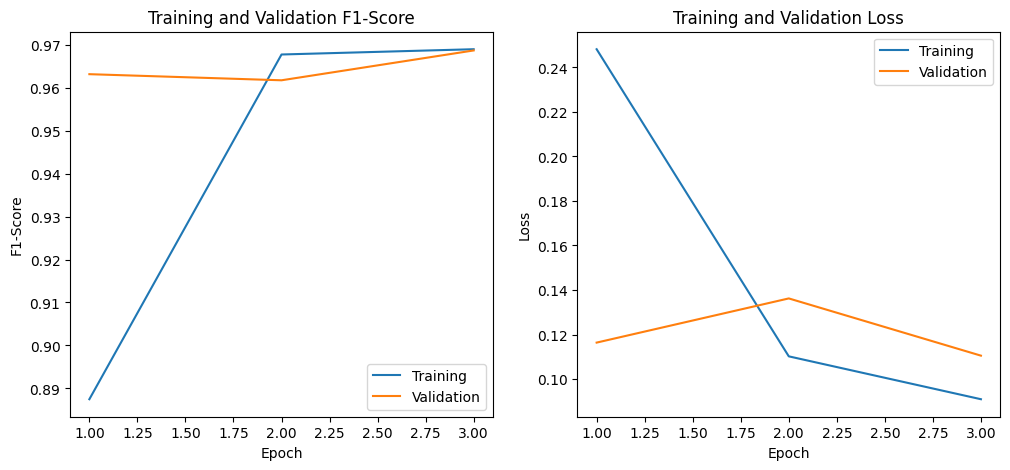

In [215]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
precision = history.history["precision"]
val_precision = history.history["val_precision"]
recall = history.history["recall"]
val_recall = history.history["val_recall"]

val_mAP = history.history["val_mAP"][-1]
print("Validation mAP:", val_mAP)

f1_score = 2 * tf.math.multiply(precision, recall) / tf.math.add(precision, recall)
val_f1_score = (
    2
    * tf.math.multiply(val_precision, val_recall)
    / tf.math.add(val_precision, val_recall)
)

epoch_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, f1_score, label="Training")
plt.plot(epoch_range, val_f1_score, label="Validation")
plt.title("Training and Validation F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label="Training")
plt.plot(epoch_range, val_loss, label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Confusion matrix


In [222]:
Y_pred = model.predict(val_ds)

Y_pred_classes = np.squeeze(np.round(Y_pred))
#Y_pred_classes=binary_mtx = tf.where(Y_pred >= 0.9, 1, 0).numpy()

Y_true = np.squeeze(np.concatenate([y for x, y in val_ds], axis=0))

confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes, num_classes=2)
print(confusion_mtx.numpy())

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 4ms/step
[[230  10]
 [  6 247]]


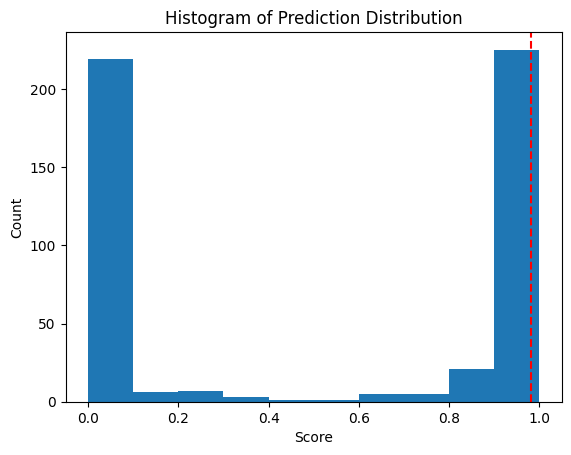

In [223]:
plt.hist(Y_pred, bins="auto")

plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Histogram of Prediction Distribution")
plt.axvline(x=val_mAP, color="r", linestyle="--")
plt.show()

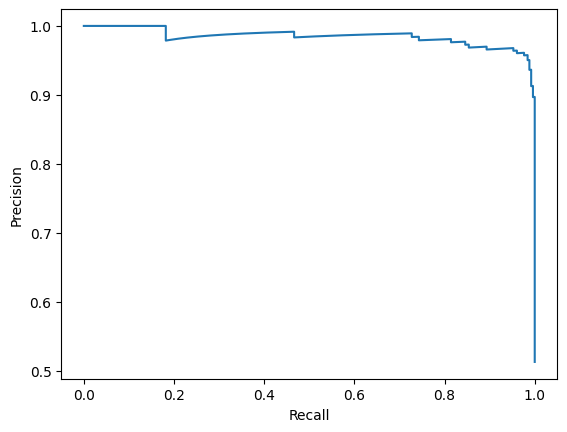

In [224]:
"""auc=roc_auc_score(Y_true, Y_pred)
fpr,tpr,tres=roc_curve(Y_true, Y_pred) used for large skew in class distribution


plt.plot(fpr,tpr)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show() """

prec, reca, tres2 = precision_recall_curve(Y_true, Y_pred)
plt.plot(reca, prec)
#plt.plot(recall, precision)
# axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")
# show the plot
plt.show()

Predicting a single example


tf.Tensor([1.], shape=(1,), dtype=float32)


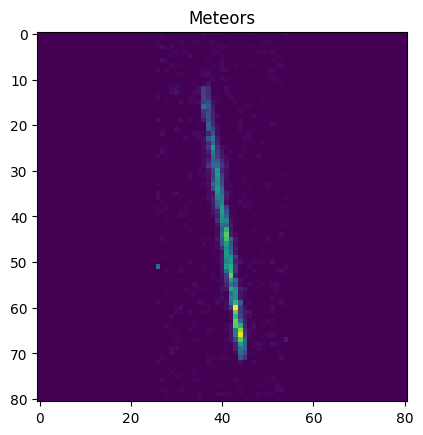

1/1 [==============================] - 0s 18ms/step
Prediction:           0.9024491906166077 - > True


In [280]:
x = val_ds.shuffle(1000).take(1)
for img, lab in x:
    print(lab[0])
    plt.figure()
    plt.imshow(img[0].numpy().astype("float32"))
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    img = img[0][np.newaxis, ...]
    prediction = model.predict(img)
    print(
        f"Prediction: \
          {prediction[0][0]} - > {class_names[int(np.round(prediction[0][0]))]==class_names[int(lab[0])]}"
    )
    break

Testing Fiachra's model


In [281]:
interpreter = tf.lite.Interpreter(model_path="meteorml32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on input data.
input_shape = input_details[0]["shape"]
correct_predictions = 0
total_predictions = 0

resize_32 = layers.Resizing(32, 32)
rescale = layers.Rescaling(1.0 / 255)
# Iterate over each batch
sample = val_ds.shuffle(1000).take(10)
for image_batch, label_batch in sample:
    total_predictions += image_batch.shape[0]
    # plt.figure()
    # img=resize_32(image_batch[0])
    # img=rescale(img)
    # img=image_batch[0]
    # print(img.numpy().max())
    # plt.imshow(img.numpy().astype("uint8"))
    # plt.title(f'{class_names[int(label_batch[0])]}')
    # plt.show()
    for i in range(image_batch.shape[0]):
        img = resize_32(image_batch[i])
        # img=rescale(img)

        """         
        plt.figure()
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(f'{class_names[int(label_batch[i])]}')
        plt.show() """
        input_data = np.expand_dims(img, axis=0)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])
        # print(output_data)
        prediction = np.argmax(output_data)  # Get the highest scoring class

        correct_predictions += prediction == label_batch[i].numpy()
        # break
    # break

print("Correct predictions:", correct_predictions)
# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Test accuracy:", accuracy)

Correct predictions: [148]
Test accuracy: [0.49169435]
